<a href="https://colab.research.google.com/github/KrisNguyen135/Advanced-Python-Programming-Second-Edition/blob/main/Chapter06/SVM_with_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import jax.numpy as jnp
from jax import grad, vmap, jit

import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from tqdm import tqdm

# Linear SVM

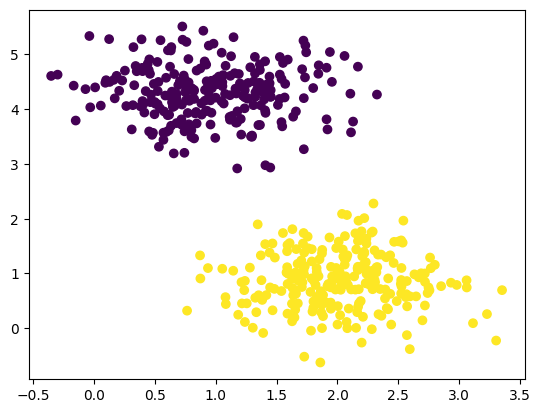

In [4]:
X, y = make_blobs(
    n_samples=500, n_features=2, centers=2, cluster_std=0.5, random_state=0
)
X = np.hstack((X, np.ones_like(y).reshape(-1, 1)))
y[y == 0] = -1

plt.scatter(X[:, 0], X[:, 1], c=y);

In [5]:
def predict(w, X):
    return jnp.dot(X, w)

def loss(w):
    preds = predict(w, X)
    return jnp.mean(jnp.clip(1 - jnp.multiply(y, preds), a_min=0))

In [6]:
np.random.seed(0)

w = np.random.randn(3)

In [7]:
n_iters = 200
lr = 0.01
loss_grad = grad(loss)

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
    grads = loss_grad(w)
    w = w - lr * grads

    tmp_loss = loss(w)
    losses[i] = tmp_loss

    pbar.set_postfix({'loss': tmp_loss})
    pbar.update()

    if tmp_loss == 0:
        break

pbar.close()

100%|██████████| 200/200 [00:02<00:00, 81.86it/s, loss=0.012640317]  


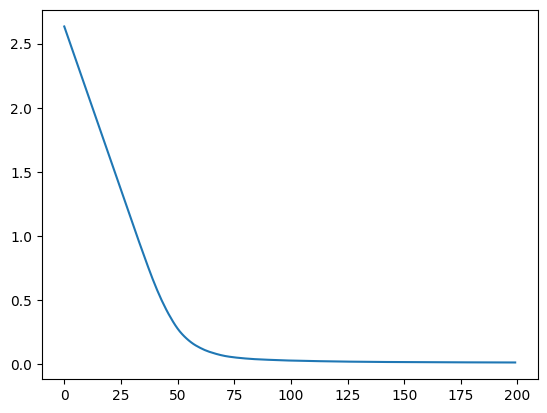

In [8]:
plt.plot(losses);

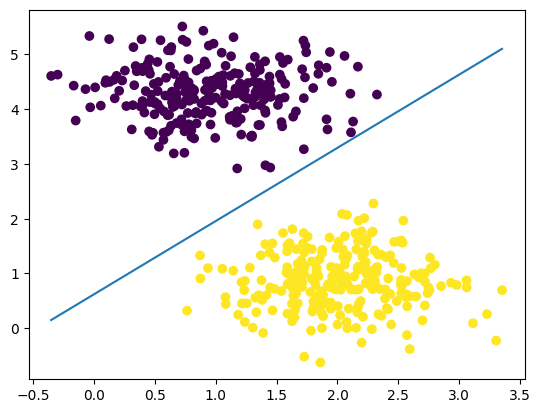

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y)

xs = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plt.plot(xs, (xs * w[0] + w[2]) / - w[1]);

## Just-in-time compiler

In [31]:
np.random.seed(0)

w = np.random.randn(3)

In [32]:
n_iters = 200
lr = 0.01
loss_grad = jit(grad(loss))

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
    grads = loss_grad(w)
    w = w - lr * grads

    tmp_loss = loss(w)
    losses[i] = tmp_loss

    pbar.set_postfix({'loss': tmp_loss})
    pbar.update()

    if tmp_loss == 0:
        break

pbar.close()

100%|██████████| 200/200 [00:01<00:00, 174.64it/s, loss=0.012640316]


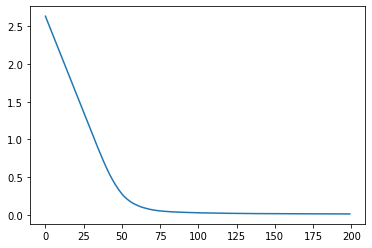

In [33]:
plt.plot(losses);

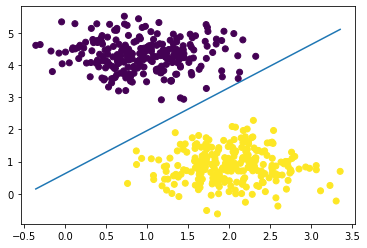

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=y)

xs = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plt.plot(xs, (xs * w[0] + w[2]) / - w[1]);

# Non-linearly separable data

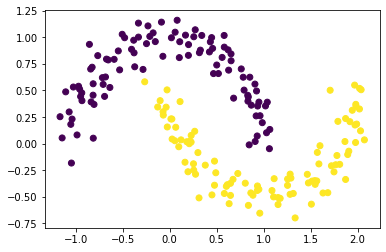

In [35]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=0)
X = np.hstack((X, np.ones_like(y).reshape(-1, 1)))
y[y == 0] = -1

plt.scatter(X[:, 0], X[:, 1], c=y);

In [36]:
np.random.seed(0)

w = np.random.randn(3)

In [37]:
n_iters = 200
lr = 0.01
loss_grad = jit(grad(loss))

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
    grads = loss_grad(w)
    w = w - lr * grads

    tmp_loss = loss(w)
    losses[i] = tmp_loss

    pbar.set_postfix({'loss': tmp_loss})
    pbar.update()

    if tmp_loss == 0:
        break

pbar.close()

100%|██████████| 200/200 [00:01<00:00, 190.12it/s, loss=0.7094709]


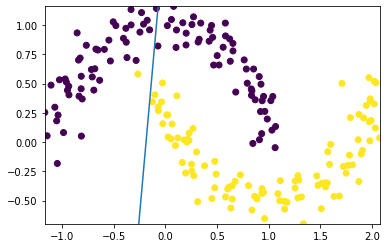

In [38]:
plt.scatter(X[:, 0], X[:, 1], c=y)

xs = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plt.plot(xs, (xs * w[0] + w[2]) / - w[1])

plt.xlim((X[:, 0].min(), X[:, 0].max()))
plt.ylim(X[:, 1].min(), X[:, 1].max());

# Kernelized SVM

In [39]:
def linear_kernel(x, z):
    return jnp.dot(x, z)


lengthscale = 0.3

def rbf_kernel(x, z):
    return jnp.exp(- jnp.linalg.norm(x - z) ** 2 / lengthscale)


def predict(alphas, X_test):
    return jnp.dot(vec_kernel(X, X_test), alphas)

def loss(alphas):
    preds = predict(alphas, X)
    return jnp.mean(jnp.clip(1 - jnp.multiply(y, preds), a_min=0))

In [40]:
kernel = rbf_kernel
vec_kernel = jit(vmap(vmap(kernel, (0, None)), (None, 0)))

np.random.seed(0)

alphas = np.random.randn(y.size)

In [41]:
n_iters = 200
lr = 0.01
loss_grad = jit(grad(loss))

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
    grads = loss_grad(alphas)
    alphas = alphas - lr * grads

    tmp_loss = loss(alphas)
    losses[i] = tmp_loss

    pbar.set_postfix({'loss': tmp_loss})
    pbar.update()

    if tmp_loss == 0:
        break

pbar.close()

100%|██████████| 200/200 [00:01<00:00, 163.67it/s, loss=0.2725643]


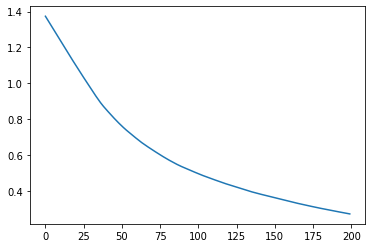

In [42]:
plt.plot(losses);

In [43]:
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

n_steps = 100

x_test_grid = np.linspace(x_min, x_max, n_steps)
y_test_grid = np.linspace(y_min, y_max, n_steps)

X1_test, X2_test = np.meshgrid(x_test_grid, y_test_grid, indexing='ij')
X_test = np.hstack((
    X1_test.reshape(-1, 1), 
    X2_test.reshape(-1, 1), 
    np.ones((n_steps ** 2, 1))
))

preds = predict(alphas, X_test)

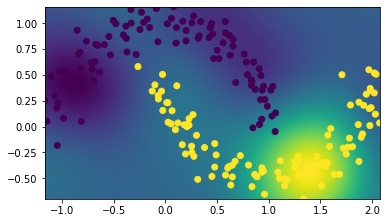

In [44]:
plt.imshow(
    preds.reshape(n_steps, n_steps).T, 
    extent=[x_min, x_max, y_min, y_max],
    origin='lower'
)

plt.scatter(X[:, 0], X[:, 1], c=y);

## Non-JIT version for comparison

In [22]:
kernel = rbf_kernel
vec_kernel = vmap(vmap(kernel, (0, None)), (None, 0))

np.random.seed(0)

alphas = np.random.randn(y.size)

In [23]:
n_iters = 200
lr = 0.01
loss_grad = grad(loss)

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
    grads = loss_grad(alphas)
    alphas = alphas - lr * grads

    tmp_loss = loss(alphas)
    losses[i] = tmp_loss

    pbar.set_postfix({'loss': tmp_loss})
    pbar.update()

    if tmp_loss == 0:
        break

pbar.close()

100%|██████████| 200/200 [00:04<00:00, 47.36it/s, loss=0.2725643]
